## Analysis of business conditions in different boroughs in New York and Toronto 
### Eric W., Mar.2020

### Libruary imported

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Geo json file loading

In [188]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [189]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Foursquare token configuration

In [69]:
CLIENT_ID = 'N2R32JAYH0O0TDDVQ3Q4I0AS2SUK2MG4PRS1POEE1M50FE1H' # your Foursquare ID
CLIENT_SECRET = 'BKKT20QYR3ZOG3ZV31RUZR00L4HP5DJB0HMI5OC2QHN4UWVM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N2R32JAYH0O0TDDVQ3Q4I0AS2SUK2MG4PRS1POEE1M50FE1H
CLIENT_SECRET:BKKT20QYR3ZOG3ZV31RUZR00L4HP5DJB0HMI5OC2QHN4UWVM


In [70]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [95]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [190]:
borough_list_NY = neighborhoods['Borough'].unique()
borough_list_NY

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [181]:
def venues_fetching(borough_list,neighborhoods):

    for n,borough in enumerate(borough_list):

        print ('Now is processing {}'.format(borough))

        df_process = neighborhoods[neighborhoods.Borough == borough]
        df_venues = getNearbyVenues(names=df_process['Neighborhood'],
                                           latitudes=df_process['Latitude'],
                                           longitudes=df_process['Longitude']
                                          )

        df_venues['Borough'] = borough

        if n==0:
            df_venues_last = df_venues.copy()

        else:
            df_venues_last = df_venues_last.append(df_venues)

    return df_venues_last

### Venues data fetching for New York

In [193]:
df_venues_NY = venues_fetching(borough_list_NY,neighborhoods)
df_venues_NY.to_excel('venues_NY.xlsx')
df_venues_NY.head()

Now is processing Bronx
Now is processing Manhattan
Now is processing Brooklyn
Now is processing Queens
Now is processing Staten Island


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Bronx
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Bronx
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Bronx
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy,Bronx
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Bronx


### Venues data fetching for Toronto

In [169]:
neighborhoods_Toronto = pd.read_excel('segmenting_and_clustering_part_2.xlsx',index_col=0)
neighborhoods_Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park,Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor,Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park / Ontario Provincial Government,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [182]:
borough_list_Toronto = neighborhoods_Toronto['Borough'].unique()

In [183]:
df_venues_Toronto = venues_fetching(borough_list_Toronto,neighborhoods_Toronto)

Now is processing North York
Now is processing Downtown Toronto
Now is processing Queen's Park / Ontario Provincial Government
Now is processing Etobicoke
Now is processing Scarborough
Now is processing East York
Now is processing York
Now is processing East Toronto
Now is processing West Toronto
Now is processing East YorkEast Toronto
Now is processing Central Toronto
Now is processing MississaugaCanada Post Gateway Processing Centre
Now is processing Downtown TorontoStn A PO Boxes25 The Esplanade
Now is processing EtobicokeNorthwest
Now is processing East TorontoBusiness reply mail Processing Centre969 Eastern


In [186]:
df_venues_Toronto.to_excel('venues_Toronto.xlsx')

### New york and Toronto venues data integration

In [393]:
df_venues_NY = pd.read_excel('venues_NY.xlsx',index_col=0)
df_venues_Toronto = pd.read_excel('venues_Toronto.xlsx',index_col=0)

df_venues_NY['City'] = 1
df_venues_Toronto['City'] = 2

In [394]:
df_venues_integration = df_venues_NY.append(df_venues_Toronto)

In [395]:
df_venues_integration.reset_index(inplace=True,drop=True)
df_venues_integration.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,City
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Bronx,1
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Bronx,1
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Bronx,1
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy,Bronx,1
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Bronx,1


### One hot processing

In [396]:
def onehot_func(df):

    # one hot encoding
    df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = df['Neighborhood'] 
    df_onehot['Borough'] = df['Borough'] 
    df_onehot['City'] = df['City'] 

    # move neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]

    #df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
    #df_grouped = df_onehot.groupby('Borough').mean().reset_index()    
    df_grouped = df_onehot.groupby('Borough').mean().reset_index()    
    
    return df_grouped

In [397]:
df_grouped = onehot_func(df_venues_integration)
df_grouped.head()

,Borough,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterr

### Data dimentionality reduction based on PCA for data visualization & clustering

In [398]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [399]:
X = df_grouped.iloc[:,2:]
label = df_grouped.iloc[:,0]

sc = StandardScaler()
X_normed = sc.fit_transform(X)

pca = PCA(n_components=2)
X_normed_PCA = pca.fit_transform(X_normed)
print ('Explained variance ratio = {}'.format(pca.explained_variance_ratio_))

Explained variance ratio = [0.20935384 0.11523038]


### Data visualization
#### by city

Text(0.5, 1.0, 'Borough similarity analysis based on City')

<Figure size 432x288 with 0 Axes>

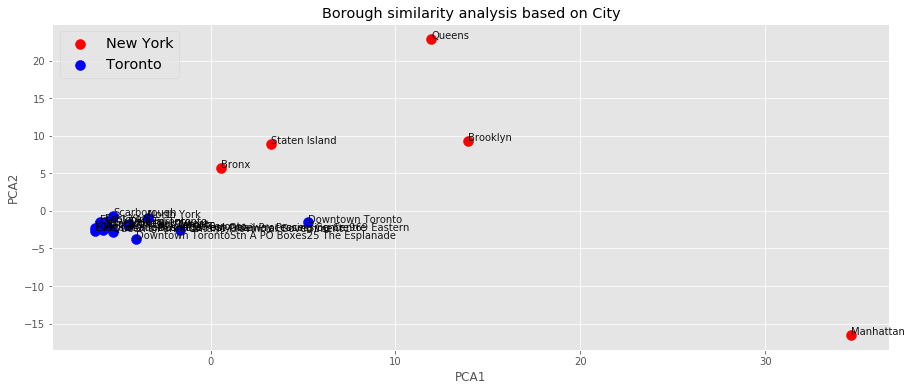

In [416]:
mpl.style.use('ggplot')

df_X_normed_PCA = pd.DataFrame(X_normed_PCA)
df_X_normed_PCA.rename(columns={0:'PCA1',1:'PCA2'},inplace=True)
df_X_normed_PCA['City'] = df_grouped['City']

fig = plt.figure()

ax0 = df_X_normed_PCA[df_X_normed_PCA.City==1].plot(kind='scatter',
                         figsize=(15, 6),
                         x='PCA1',y='PCA2',
                         s=100,
                         c='r')

ax1 = df_X_normed_PCA[df_X_normed_PCA.City==2].plot(kind='scatter',
                         figsize=(15, 6),
                         x='PCA1',y='PCA2',
                         s=100,
                         c='b',
                         ax = ax0)

for i in range(X_normed_PCA.shape[0]):
    plt.annotate(label[i], xy=(X_normed_PCA[i,0],X_normed_PCA[i,1]), color='black',fontsize = 10,alpha=0.9)

ax0.legend(['New York', 'Toronto'], loc='upper left', fontsize='x-large')
ax0.set_ylabel('PCA1')
ax0.set_ylabel('PCA2')
ax0.set_title('Borough similarity analysis based on City')

### Borough cluster processing

In [401]:
# set number of clusters
kclusters = 4

df_grouped_clustering = X_normed_PCA

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 0])

### Data visualization
#### by cluster

Text(0.5, 1.0, 'Borough cluster')

<Figure size 432x288 with 0 Axes>

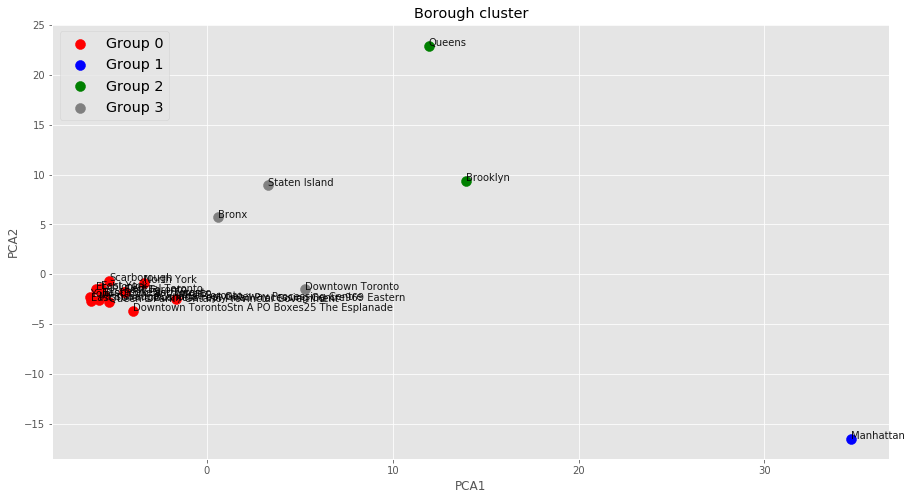

In [417]:
mpl.style.use('ggplot') # optional: for ggplot-like style

df_X_normed_PCA = pd.DataFrame(X_normed_PCA)
df_X_normed_PCA.rename(columns={0:'PCA1',1:'PCA2'},inplace=True)
df_X_normed_PCA['cluster_'] = kmeans.labels_

fig = plt.figure()

ax0 = df_X_normed_PCA[df_X_normed_PCA.cluster_==0].plot(kind='scatter',
                         figsize=(15, 8),
                         x='PCA1',y='PCA2',
                         s=100,
                         c='r')

ax1 = df_X_normed_PCA[df_X_normed_PCA.cluster_==1].plot(kind='scatter',
                         x='PCA1',y='PCA2',
                         s=100,
                         c='b',
                         ax = ax0)

ax1 = df_X_normed_PCA[df_X_normed_PCA.cluster_==2].plot(kind='scatter',
                         x='PCA1',y='PCA2',
                         s=100,
                         c='g',
                         ax = ax0)

ax1 = df_X_normed_PCA[df_X_normed_PCA.cluster_==3].plot(kind='scatter',
                         x='PCA1',y='PCA2',
                         s=100,
                         c='grey',
                         ax = ax0)

for i in range(X_normed_PCA.shape[0]):
    plt.annotate(label[i], xy=(X_normed_PCA[i,0],X_normed_PCA[i,1]), color='black',fontsize = 10,alpha=0.9)

ax0.legend(['Group 0', 'Group 1','Group 2','Group 3'], loc='upper left', fontsize='x-large')
ax0.set_ylabel('PCA1')
ax0.set_ylabel('PCA2')
ax0.set_title('Borough cluster')

### Borough data aggregation based on cluster and add the top 10 venues information for each borough

In [413]:
df_grouped_cluser = df_grouped.copy()
df_grouped_cluser['cluster_'] = df_X_normed_PCA['cluster_']
df_grouped_cluser = df_grouped_cluser.groupby('cluster_').mean()

df_grouped_cluser.reset_index(inplace=True)
df_grouped_cluser.pop('City')
df_grouped_cluser

,cluster_,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranea

In [414]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:-1]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['cluster_']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['cluster_'] = df_grouped_cluser['cluster_']

for ind in np.arange(df_grouped_cluser.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped_cluser.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,cluster_,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Park,Coffee Shop,Rental Car Location,Drugstore,Convenience Store,Pizza Place,Sandwich Place,Café,Fast Food Restaurant,Restaurant
1,1,Coffee Shop,Italian Restaurant,American Restaurant,Café,Pizza Place,Bakery,Hotel,Cocktail Bar,Park,Mexican Restaurant
2,2,Pizza Place,Deli / Bodega,Bar,Chinese Restaurant,Bakery,Coffee Shop,Pharmacy,Italian Restaurant,Donut Shop,Grocery Store
3,3,Pizza Place,Coffee Shop,Italian Restaurant,Deli / Bodega,Bus Stop,Café,Sandwich Place,Pharmacy,Restaurant,Grocery Store


### END